# Fehlerprotokolle in Bezug auf Code Ownership nach Teilprojekten

Diese Analyse beschäftigt sich mit aufgetretenen Fehlerprotokollen im Produktionssystem in Bezug auf die Code Ownership Werte des jeweiligen Teilprojekts.

## Laden relevanter Daten aus der Datenbank

Als erster Schritt werden die für die Analyse relevanten Daten aus der Datenbank geladen. Dabei wird die Anzahl an Fehlerprotokollen für einen bestimmten Code Ownership Wert eines Teilprojektes betrachtet.

Das Code Ownership wird anhand der Anzahl der Commits und geänderten Codezeilen berechnet.
Die entsprechende Formel zu Berechnung des Anteils einer einzelnen Person $P$ zum Zeitpunkt $t$ lautet: 

$
\textrm{Ownership}(P)_t = 
    \frac{
        \frac{\textrm{Commits}(p)_t}{\textrm{Commits} _t}
        +\frac{\textrm{LoCC}(p)_t}{\textrm{LoCC} _t}
    }
    {2}
$

Das Code-Ownership des Teilprojekts ist der maximale Wert aus der Liste der persönlichen Anteile der Beteiligten.

In [1]:
import shared.paths as paths
import shared.locals as locals
from tinydb.queries import where
from helpers.config import Configuration
from database.models import ErrorLog, Project
from database.database import Database
from shared.calculation import query_and_calculate_ownership

database = Database(paths.DATABASE_PATH, cached=True)
config = Configuration.from_input_file(paths.CONFIG_PATH)

results = {}
projects = database.query(Project.LABEL, where("log_groups") != [])

for project in projects:
    project_result = {}
    for error in database.query(ErrorLog.LABEL,
        (where("account") == "production") & (where("loggroup").one_of(project.log_groups))):

        ownership = query_and_calculate_ownership(database, project.id, error.timestamp)
        if not ownership in project_result:
            project_result[ownership] = 0
        project_result[ownership] += 1
    
    if project_result:
        results[project.id] = project_result

## Visualisierung der Daten

Im zweiten Schritt werden die Daten anhand eines Streudiagramms dargestellt.

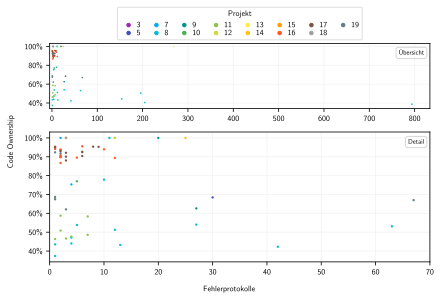

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(locals.TEXTWIDTH, 4), gridspec_kw={"height_ratios": [1, 2]})

for project_id, result in results.items():
    x = list(result.values())
    y = list(result.keys())

    ax1.scatter(x, y,
        color=locals.PROJECTS[project_id]["color"], marker='.', s=2, label=locals.PROJECTS[project_id]["id"], zorder=1)
    
    ax2.scatter(x, y,
        color=locals.PROJECTS[project_id]["color"], marker='.', s=8, label=locals.PROJECTS[project_id]["id"], zorder=1)

legend = ax1.legend(title="Projekt", loc="upper center", bbox_to_anchor=(0.5, 1.62),
    ncol=8, labelspacing=0.1, columnspacing=1, handletextpad=0, edgecolor=locals.FRAME_GRAY)
for handle in legend.legendHandles:
    handle.set_sizes([50])
legend._legend_box.sep = 4

props = dict(boxstyle="round", facecolor="white", edgecolor=locals.FRAME_GRAY, pad=0.4)
ax1.text(0.985, 0.9, "Übersicht", fontsize="small", bbox=props,
    horizontalalignment="right", verticalalignment="top", transform=ax1.transAxes)
ax2.text(0.985, 0.9, "Detail", fontsize="small", bbox=props,
    horizontalalignment="right", verticalalignment="bottom", transform=ax2.transAxes)

ax1.set_xlim(left=-5)
ax2.set_xlim([0,70])
ax1.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax1.grid(color=locals.GRID_GRAY)
ax2.grid(color=locals.GRID_GRAY)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

fig.text(0.5, -0.02, "Fehlerprotokolle", ha="center")
fig.text(-0.02, 0.5, "Code Ownership", va="center", rotation="vertical")

plt.tight_layout()
plt.show()

## Erstellung der Wertetabelle

Als letzter Schritt wird die entsprechende Wertetabelle angelegt. Zusätzlich wird eine Übersichtstabelle angelegt.

In [3]:
import math
from IPython.display import display, HTML, Markdown
from tabulate import tabulate

display(Markdown("**Übersichtstabelle**"))

table_rows = [["Bereich"],["Fehlerprotokolle"]]

categories = {i: 0 for i in range(10,101,10)}

for result in results.values():
    for ownership, errors in result.items():
        category = int(math.ceil(ownership * 10.0)* 10.0)
        categories[category] += errors

for category in categories.keys():
    table_rows[0].append(f"{category-10 if category == 10 else category-9}-{category} %")
    table_rows[1].append(categories[category])

display(HTML(tabulate(tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center")))


display(Markdown("**Wertetabelle**"))

table_headers = ["Code Ownership"]
mapping = {}

for index, (project, result) in enumerate(results.items()):
    table_headers.append(locals.PROJECTS[project]["id"])
    for ownership, errors in result.items():
        if (ownership_str := math.ceil(ownership * 1000.0) / 1000.0) not in mapping:
            mapping[ownership_str] = ["-" for project in range(len(results))]
        mapping[ownership_str][index] = errors

table_rows = []

for ownership, result in sorted(mapping.items(), reverse=True):
    row = [f"{ownership:.3f}"]
    row.extend(result)
    table_rows.append(row)

display(HTML(tabulate(headers=table_headers,
    tabular_data=table_rows,
    tablefmt="html", stralign="center", numalign="center")))

**Übersichtstabelle**

Bereich,0-10 %,11-20 %,21-30 %,31-40 %,41-50 %,51-60 %,61-70 %,71-80 %,81-90 %,91-100 %
Fehlerprotokolle,0,0,0,795,438,314,130,19,26,433


**Wertetabelle**

Code Ownership,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19
1,3,-,2,11,20,12,-,12,268,25,3,-,-,3,-
0.956,-,-,-,-,-,-,-,-,-,-,-,6,-,-,-
0.954,-,-,-,-,-,-,-,-,-,-,-,1,8,-,-
0.953,-,-,-,-,-,-,-,-,-,-,-,-,9,-,-
0.952,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-
0.951,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-
0.942,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-
0.94,-,-,-,-,-,-,-,-,-,-,-,10,-,-,-
0.938,-,-,-,-,-,-,-,-,-,-,-,2,-,-,-
0.937,-,-,-,-,-,-,-,-,-,-,-,2,-,-,-
